In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection')

In [ ]:
import numpy as np
import seaborn as sns
import codecs
from tqdm import tqdm
from keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of unique words:  123659


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of news: 16646
Median length of the news: 317


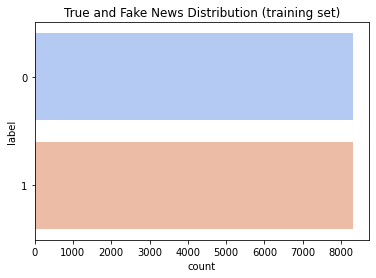

Number of True News in the Training Set: 8323
Number of Fake News in the Training Set: 8323


In [ ]:
from data_preprocessing_fulldataset import unique_words, padded_train, padded_test, Y_train, Y_test, median, word_index

# Best Model

Pre-trained Word Embedding with FastText

In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [01:09, 14312.39it/s]

found 999995 word vectors


In [ ]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(unique_words, len(word_index))+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 59785


In [ ]:
best_model= Sequential()

best_model.add(Embedding(nb_words, output_dim = 300, input_length=median, weights=[embedding_matrix]))

best_model.add(Conv1D(filters=128, kernel_size=3, activation="relu"))
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.1))

best_model.add(Conv1D(filters=128, kernel_size=3, activation = "relu"))    
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.1)) 

best_model.add(Conv1D(filters=128, kernel_size=3, activation = "relu"))    
best_model.add(MaxPooling1D(2))
best_model.add(Dropout(0.1)) 
                                  
best_model.add(Bidirectional(LSTM(64, return_sequences=True)))
best_model.add(GlobalMaxPool1D())
best_model.add(Dropout(0.1))

best_model.add(Dense(64, activation="relu"))
best_model.add(Dense(1, activation="sigmoid"))

best_model.compile(optimizer=Adam(lr=0.001, clipnorm=5), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 317, 300)          35958600  
                                                                 
 conv1d (Conv1D)             (None, 315, 128)          115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 157, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 157, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 155, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 77, 128)          0         
 1D)                                                    

# Best Model Retraining on full dataset

In [ ]:
# Train loss achieved with Model Selection
train_thold = 0.0015

In [ ]:
# Stopping criterion (Retrain until the loss is above the threshold)

class SOMT(Callback):

    def __init__(self, model,  train_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        
    def on_epoch_end(self,epoch, logs={}): 
        tr_loss=logs.get('loss')
        if tr_loss <= self.train_thold:
            self.model.stop_training = True # stop training
            print( f'\nTraining stopped because loss reached the threshold')

In [ ]:
Y_train = np.asarray(Y_train)

In [ ]:
# Retraining Best Model
es = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
history = best_model.fit(padded_train, Y_train, batch_size=64, epochs=30, callbacks=[es, SOMT(best_model, train_thold)])

Epoch 1/30
261/261 [==============================] - 17s 39ms/step - loss: 0.1850 - accuracy: 0.9098
Epoch 2/30
261/261 [==============================] - 9s 36ms/step - loss: 0.0250 - accuracy: 0.9923
Epoch 3/30
261/261 [==============================] - 9s 36ms/step - loss: 0.0099 - accuracy: 0.9968
Epoch 4/30
261/261 [==============================] - 10s 37ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 5/30
261/261 [==============================] - ETA: 0s - loss: 3.5929e-04 - accuracy: 1.0000
Training stopped because loss reached the threshold
261/261 [==============================] - 9s 36ms/step - loss: 3.5929e-04 - accuracy: 1.0000


In [ ]:
best_ep = np.argmin(history.history["loss"][:-1])+1

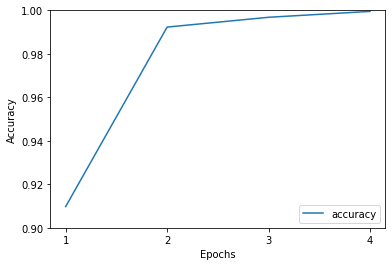

In [ ]:
#Accuracy plot
plt.plot(history.history["accuracy"][0:best_ep], label='accuracy')       
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9,1])
plt.xticks(np.arange(len(history.history["accuracy"][0:best_ep])), np.arange(1, len(history.history["accuracy"][0:best_ep])+1))
plt.legend(loc = 'lower right')

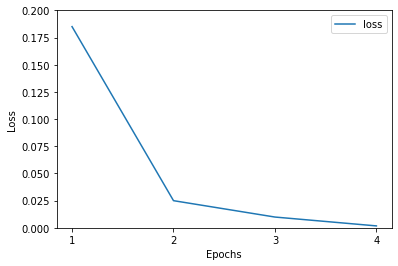

In [ ]:
#Loss plot
plt.plot(history.history["loss"][0:best_ep], label='loss')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.2])
plt.xticks(np.arange(len(history.history["loss"][0:best_ep])), np.arange(1, len(history.history["loss"][0:best_ep])+1))
plt.legend(loc = 'upper right')

# Best Model Performance on Test Set


## Classification Threshold 0.50

In [ ]:
pred = (best_model.predict(padded_test) > 0.5)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9760    0.9859    0.9809      1979
           1     0.9862    0.9767    0.9814      2056

    accuracy                         0.9812      4035
   macro avg     0.9811    0.9813    0.9812      4035
weighted avg     0.9812    0.9812    0.9812      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.12 %


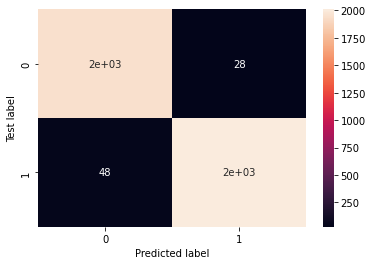

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting The Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

# Best Model Performance on Test Set with different Classification Thresholds

## Classification Threshold 0.80

In [ ]:
pred = (best_model.predict(padded_test) > 0.8)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9712    0.9884    0.9797      1979
           1     0.9886    0.9718    0.9801      2056

    accuracy                         0.9799      4035
   macro avg     0.9799    0.9801    0.9799      4035
weighted avg     0.9801    0.9799    0.9799      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.99 %


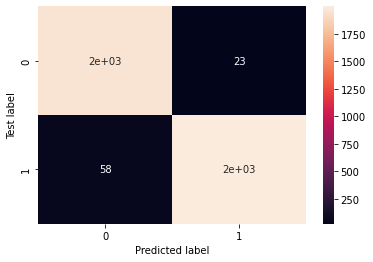

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.90

In [ ]:
pred = (best_model.predict(padded_test) > 0.9)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9656    0.9919    0.9786      1979
           1     0.9920    0.9660    0.9788      2056

    accuracy                         0.9787      4035
   macro avg     0.9788    0.9789    0.9787      4035
weighted avg     0.9790    0.9787    0.9787      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.87 %


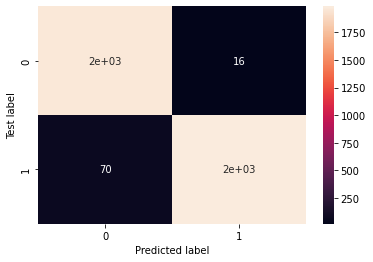

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.95

In [ ]:
pred = (best_model.predict(padded_test) > 0.95)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9614    0.9939    0.9774      1979
           1     0.9940    0.9616    0.9775      2056

    accuracy                         0.9774      4035
   macro avg     0.9777    0.9778    0.9774      4035
weighted avg     0.9780    0.9774    0.9774      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.74 %


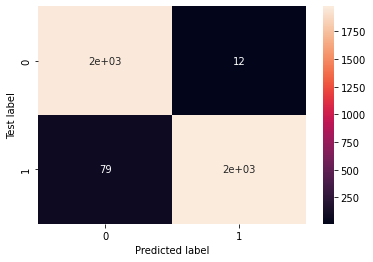

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.99

In [ ]:
pred = (best_model.predict(padded_test) > 0.99)

In [ ]:
# Getting the Classification Report
print(classification_report(list(Y_test), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9508    0.9960    0.9729      1979
           1     0.9959    0.9504    0.9726      2056

    accuracy                         0.9727      4035
   macro avg     0.9734    0.9732    0.9727      4035
weighted avg     0.9738    0.9727    0.9727      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(Y_test), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.27 %


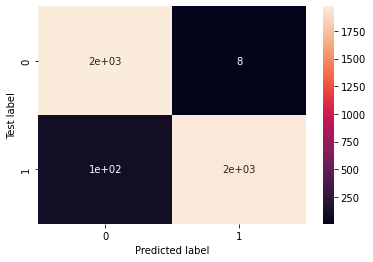

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(Y_test), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()